In [67]:
## Import dependencies
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as signal

In [68]:
## Create faceDetector Object

## Define the models
base_model="blaze_face_short_range.tflite"
base_options = python.BaseOptions(model_asset_path=base_model)

## Mediapipe configuration options
FaceDetectorOptions = vision.FaceDetectorOptions
VisionRunningMode = vision.RunningMode
options = FaceDetectorOptions(
    base_options=base_options,
    running_mode = VisionRunningMode.IMAGE,
)
face_detector = vision.FaceDetector.create_from_options(options)

In [69]:
## Create Pose Landmarker Object

## Define the models
model_path = "pose_landmarker.task"
BaseOptions = mp.tasks.BaseOptions

PoseLandmarkerOptions = vision.PoseLandmarkerOptions
VisionRunningMode = vision.RunningMode

options_image = PoseLandmarkerOptions(
    base_options=BaseOptions(
        model_asset_path=model_path,
    ),
    running_mode=VisionRunningMode.IMAGE,
    num_poses=1,
    min_pose_detection_confidence=0.5,
    min_pose_presence_confidence=0.5,
    min_tracking_confidence=0.5,
    output_segmentation_masks=False
)

pose_landmarker = vision.PoseLandmarker.create_from_options(options_image)

<h1>POS (Plane-Orthogonal to Skin)</h1>

In [71]:
## Core method POS 
def POS(signal, **kargs):
    """
    POS method on CPU using Numpy.

    The dictionary parameters are: {'fps':float}.

    Wang, W., den Brinker, A. C., Stuijk, S., & de Haan, G. (2016). Algorithmic principles of remote PPG. IEEE Transactions on Biomedical Engineering, 64(7), 1479-1491. 
    """
    """
    eps: A small constant (10^-9) used to prevent division by zero in normalization steps.
    X: The input signal, which is a 3D array where:
    e: Number of estimators or regions in the frame (like different parts of the face).
    c: Color channels (3 for RGB).
    f: Number of frames.
    w: Window length, determined by the camera's frame rate (fps). For example, at 20 fps, w would be 32 (which corresponds to about 1.6 seconds of video).
    """
    eps = 10**-9
    X = signal
    e, c, f = X.shape # Number of estimators, color channels, and frames
    w = int(1.6 * kargs['fps']) # Window length in frames

    """
    P: A fixed 2x3 matrix used for the projection step. It defines how to transform the color channels (RGB) into a new space.
    Q: This is a stack of the matrix P repeated e times, where each P corresponds to an estimator (region of interest) in the video.
    """
    P = np.array([[0, 1, -1], [-2, 1, 1]])
    Q = np.stack([P for _ in range(e)], axis = 0)

    """
    H: A matrix to store the estimated heart rate signal over time for each estimator.
    n: The current frame in the sliding window.
    m: The start index of the sliding window (calculating which frames are part of the current window).
    """
    H = np.zeros((e, f))
    for n in np.arange(w, f):
        # Start index of sliding window 
        m = n - w + 1

        """
        Temporal Normalization (Equation 5 from the paper): This step ensures that the signal is invariant to global lighting changes and other noise factors.
        """
        Cn = X[:, :, m:(n+1)]
        M = 1.0 / (np.mean(Cn, axis = 2) + eps)
        M = np.expand_dims(M, axis=2) # shape [e, c, w]
        Cn = np.multiply(Cn, M)

        """
        Projection (Equation 6 from the paper): This step transforms the RGB values into a space where the signal from blood flow (heart rate) is more distinct.
        """
        S = np.dot(Q, Cn)
        S = S[0, :, :, :]
        S = np.swapaxes(S, 0, 1) 

        """
        Tuning (Equation 7 from the paper): This step adjusts the projected components to make the heart rate signal clearer.
        """
        S1 = S[:, 0, :]
        S2 = S[:, 1, :]
        alpha = np.std(S1, axis=1) / (eps + np.std(S2, axis=1))
        alpha - np.expand_dims(alpha, axis=1)
        Hn = np.add(S1, alpha * S2)
        Hnm = Hn - np.expand_dims(np.mean(Hn, axis=1), axis=1)

        """
        Overlap-Adding (Equation 8 from the paper): This step combines the processed signals from each frame to form the final output heart rate signal.
        """
        H[:, m:(n + 1)] = np.add(H[:, m:(n + 1)], Hnm)  # Add the tuned signal to the output matrix

    return H


In [72]:
## Some variables, containers, constants and buffer
r_signal, g_signal, b_signal = [], [], [] ## For storing RGB value from the skin
fps = 35 ## Frame rate of the camera
time_window = 60 # Time window in seconds
frame_buffer_limit = time_window * fps ## Number of frames to be processed, since toby-rgb is 60 seconds
frame_buffer = [] ## Buffer for storing frames
margin_x = 10  # Adjust horizontally
scaling_factor = 0.8 # Scaling factor for the bounding box


Error: Could not read frame.


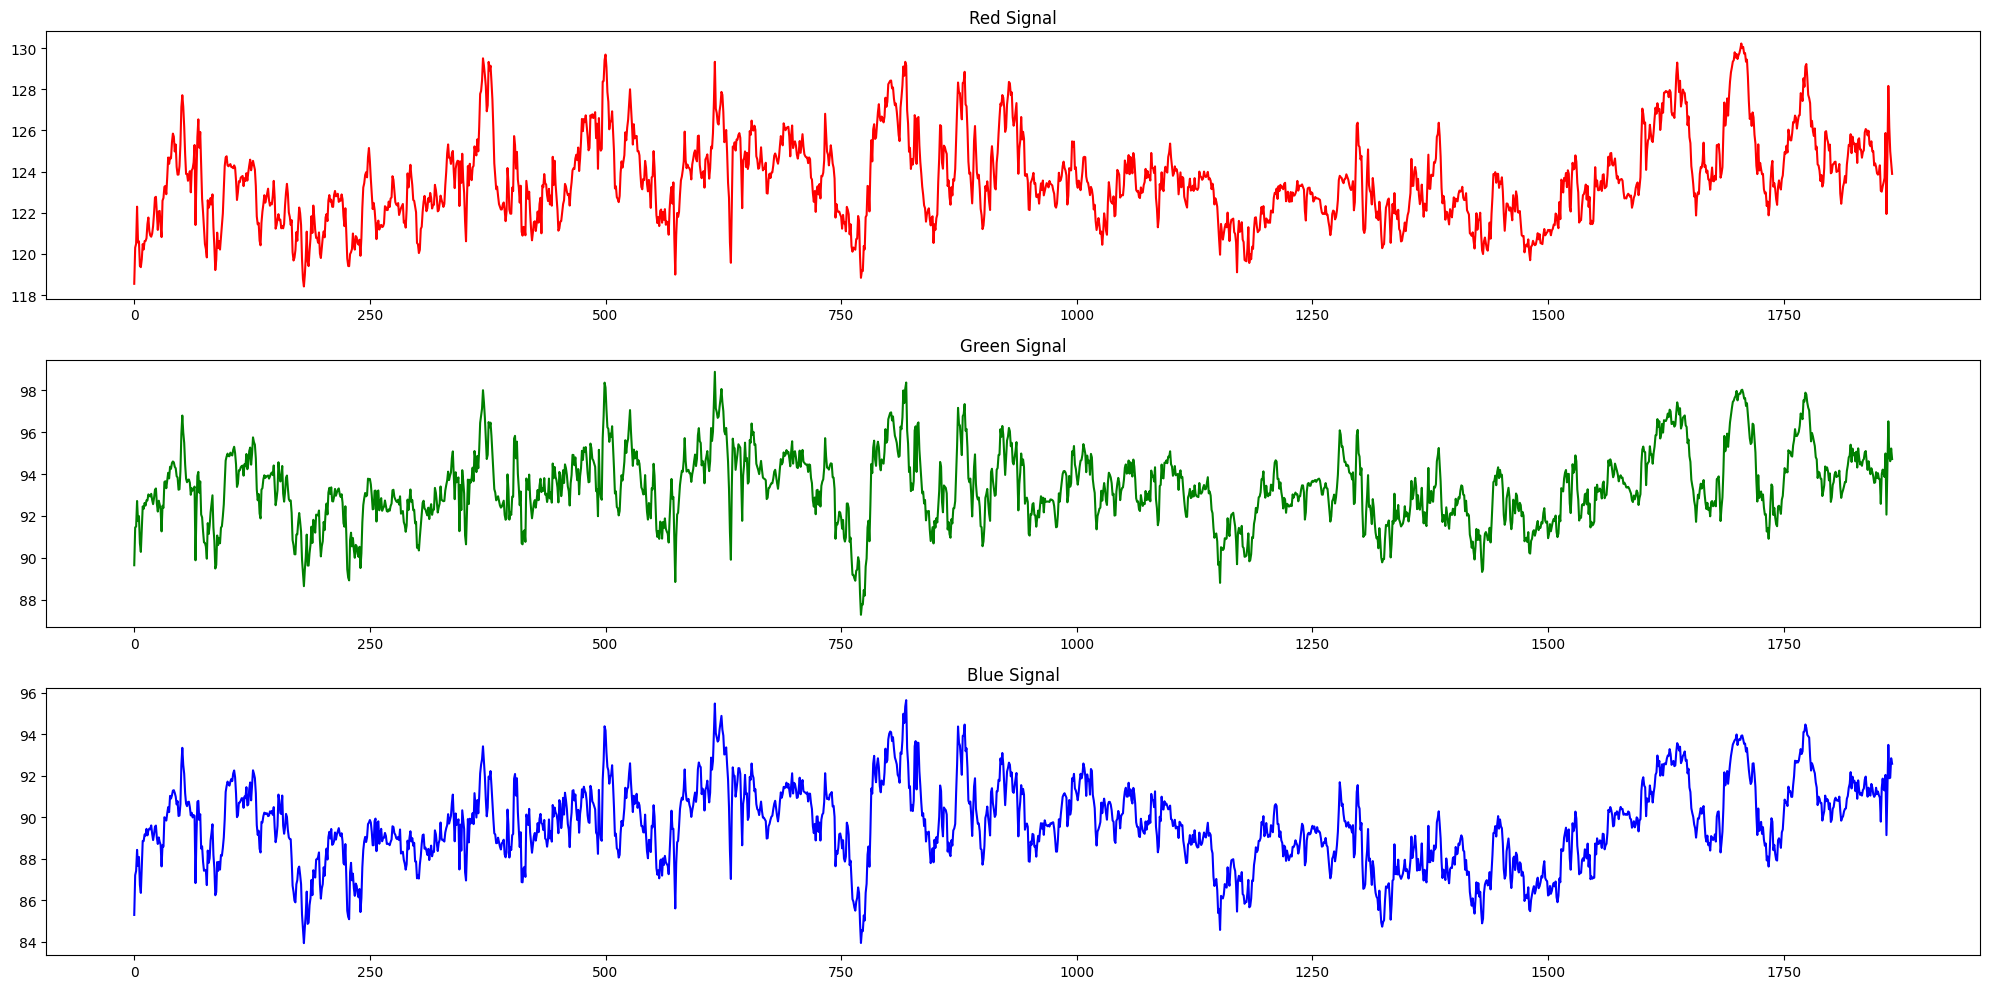

In [73]:
try:
    ## Load the Video
    file_path = os.path.join("Resp_Bintang.mp4") ## Path to the video file
    
    ## Put 0 to use the camera, or use the video file path for analyzing a video
    cap = cv2.VideoCapture(file_path) 

    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    ## Untuk mendapatkan 60 detik video.
    while len(frame_buffer) < frame_buffer_limit:

        ## Read the frame from the camera
        ret, frame = cap.read() 
        if not ret:
            print("Error: Could not read frame.")
            break

        ## Adding the frame_buffer to the list
        frame_buffer.append(frame)


        ## Convert the frame to RGB
        ## Karena default dari OpenCV adalah BGR, kita perlu mengkonversi ke RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        ## Seting up the Mediapipe Image
        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=rgb_frame
        )

        ## Process the frame using the face detector
        result = face_detector.detect(mp_image)

        """
        Where the magic happens:

        Proses ini melakukan deteksi wajah pada frame video untuk mendapatkan bounding box wajah.
        Kemudian, bounding box ini digunakan untuk mendapatkan ROI (Region of Interest) dari wajah, yang kemudian digunakan 
        untuk menghitung nilai rata-rata RGB dari area tersebut. 

        Nilai rata-rata RGB ini disimpan dalam list r_signal, g_signal, dan b_signal untuk analisis lebih lanjut.
        """
        if result.detections:
            for detection in result.detections:

                ## Get the Bounding box
                bboxC = detection.bounding_box
                x, y, w, h = bboxC.origin_x, bboxC.origin_y, bboxC.width, bboxC.height

                ## Setup tipis tipis biar boxnya pas di tengah wajah
                new_x = int(x + margin_x)
                new_w = int(w * scaling_factor)
                new_h = int(h * scaling_factor)

                ## Get the ROI
                face_roi = rgb_frame[y:y+new_h, new_x:new_x+new_w]
            
                ## Draw the bounding box on the frame
                cv2.rectangle(frame, (int(x), int(y)), (int(x + new_w), int(y + new_h)), (0, 255, 0), 2)

                ## Calculate the Mean RGB values of the face ROI
                mean_rgb = cv2.mean(face_roi)[:3]
                
                # Append the combined RGB values to the respective lists
                r_signal.append(mean_rgb[0])
                g_signal.append(mean_rgb[1])
                b_signal.append(mean_rgb[2])

        # Show the frame
        cv2.imshow("frame", frame) 

        # Check if 'q' is pressed or the window is closed
        if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("frame", cv2.WND_PROP_VISIBLE) < 1:
            break

except Exception as e:
    print(f"An error occurred: {e}")
    cap.release()
    cv2.destroyAllWindows()

finally:
    ## Release the camera and close all windows
    cap.release()
    cv2.destroyAllWindows()

    ax, fig = plt.subplots(3, 1, figsize=(20, 10))
    fig[0].plot(r_signal, color='red')
    fig[0].set_title('Red Signal')
    fig[1].plot(g_signal, color='green')
    fig[1].set_title('Green Signal')
    fig[2].plot(b_signal, color='blue')
    fig[2].set_title('Blue Signal')
    plt.tight_layout()
    plt.show()

<h1>Post-Processing rPPG signals</h1>

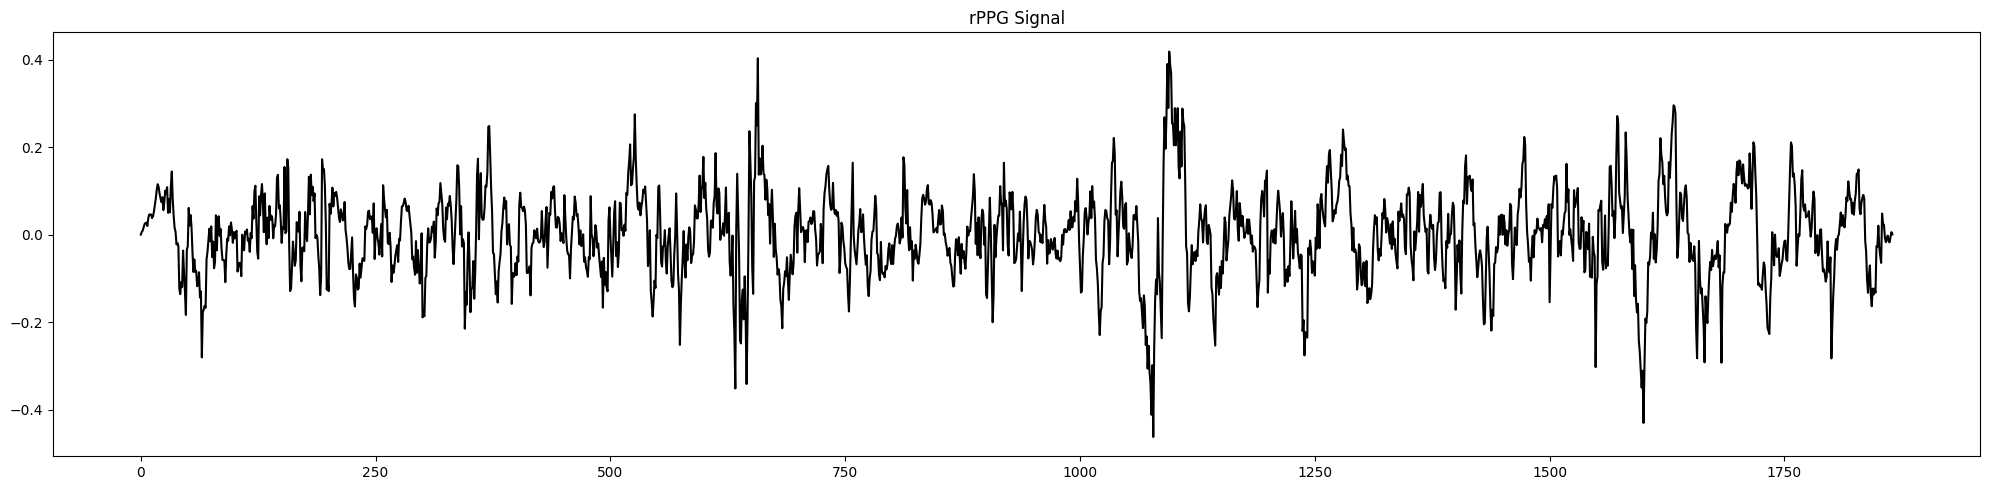

In [74]:
# Menghitung rPPG menggunakan Metode POS
rgb_signals = np.array([r_signal, g_signal, b_signal])
rgb_signals = rgb_signals.reshape(1, 3, -1)
rppg_signal = POS(rgb_signals, fps=30)
rppg_signal = rppg_signal.reshape(-1)

# 6.1 Menampilkan grafik Sinyal rPPG
plt.figure(figsize=(20, 5))
plt.plot(rppg_signal, color='black')
plt.title('rPPG Signal')
plt.tight_layout()
plt.show()


<h1>Post-Processing dan Analysis</h1>

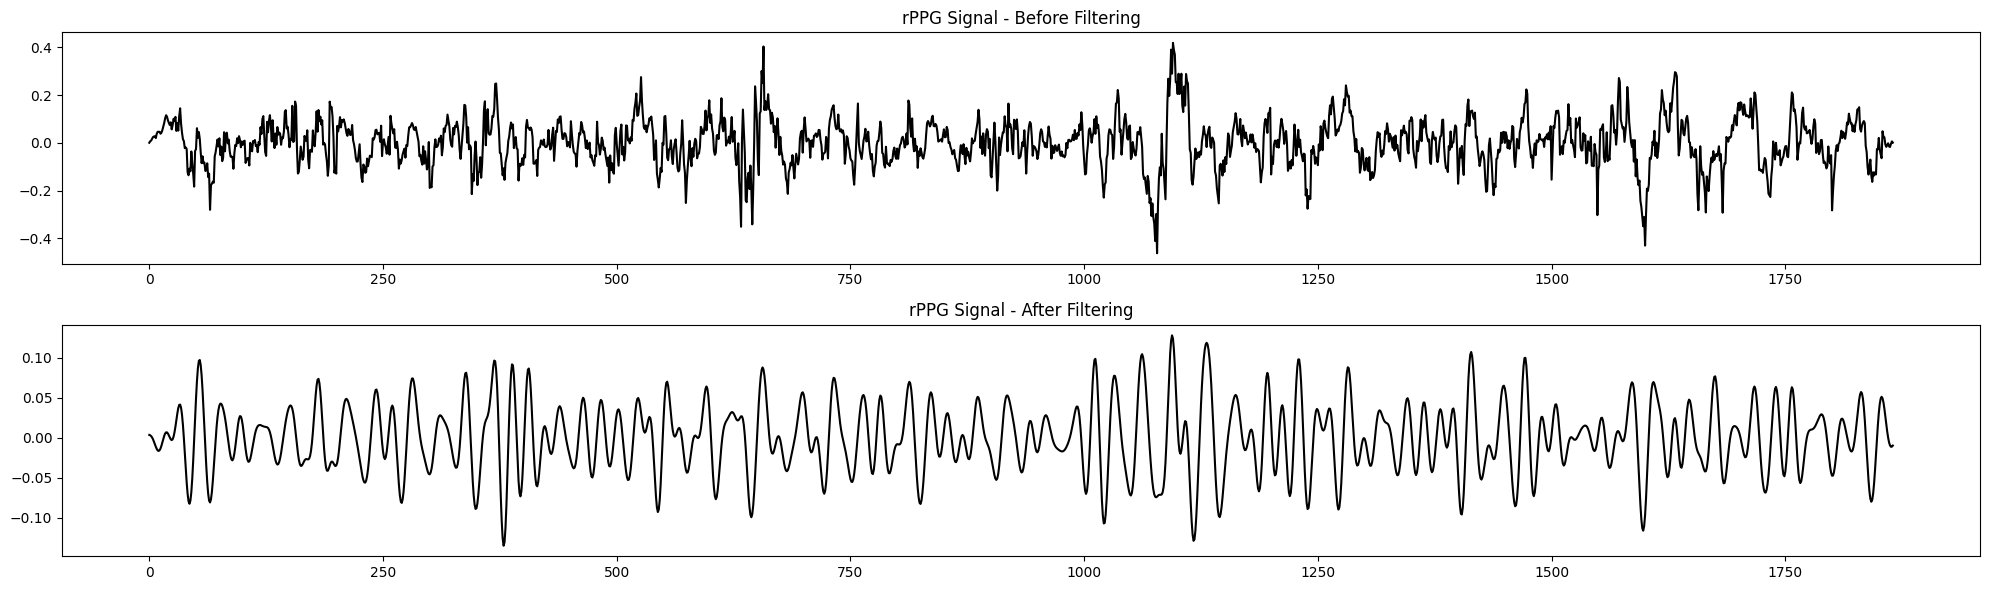

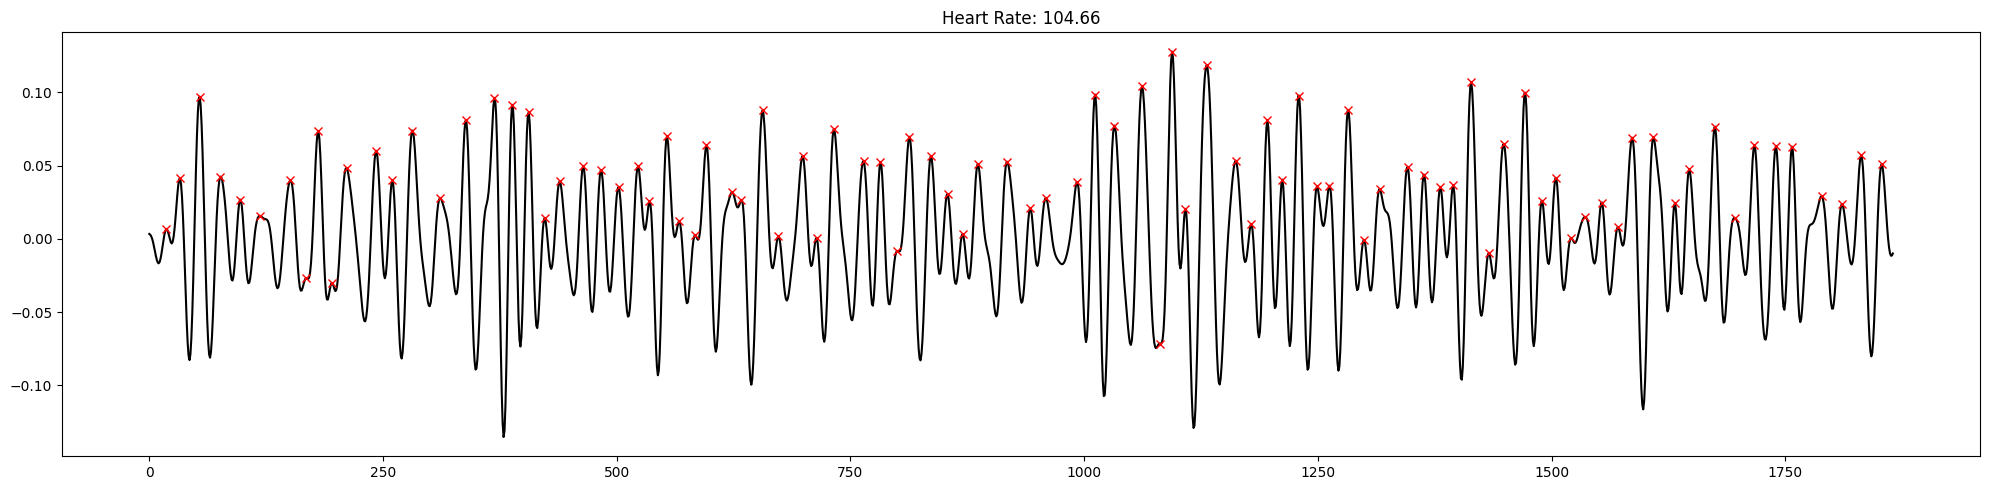

In [75]:
# Memfilter Sinyal rPPG
fs = 35; lowcut = 0.9; highcut = 2.4; order = 3
b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
filtered_rppg = signal.filtfilt(b, a, rppg_signal)

fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(rppg_signal, color='black')
ax[0].set_title('rPPG Signal - Before Filtering')
ax[1].plot(filtered_rppg, color='black')
ax[1].set_title('rPPG Signal - After Filtering')
plt.tight_layout()
plt.show()

# Mencari puncak sinyal
peaks, _ = signal.find_peaks(
    x=filtered_rppg,
)

# Menghitung heart rate
heart_rate = 60 * len(peaks) / (len(filtered_rppg) / fs)

# Menampilkan grafik puncak sinyal
plt.figure(figsize=(20, 5))
plt.plot(filtered_rppg, color='black')
plt.plot(peaks, filtered_rppg[peaks], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()


<h1>Respiration - The Rhythm Beneath the Breath 🌬️</h1>

<h2>Mediapipe Pose Landmarker</h2>

In [60]:
## Setup variables, constants and etc..
resp_signal = []
fps = 35 ## Frame rate of the camera
time_window = 60 # Time window in seconds
frame_buffer_limit = time_window * fps ## Number of frames to be processed, since toby-rgb is 60 seconds
frame_buffer = [] ## Buffer for storing frames
features = None # for storing the features optical flow.
lk_params = None ## Lucas-Kanade parameters
old_gray = None ## Old gray frame
left_x, top_y, right_x, bottom_y = None, None, None, None ## Coordinates for the ROI
STANDARD_SIZE = (640, 480)  # Pick whatever size you want

In [61]:
## Create Pose Landmarker Object

## Define the models
model_path = "pose_landmarker.task"
BaseOptions = mp.tasks.BaseOptions

PoseLandmarkerOptions = vision.PoseLandmarkerOptions
VisionRunningMode = vision.RunningMode

options_image = PoseLandmarkerOptions(
    base_options=BaseOptions(
        model_asset_path=model_path,
    ),
    running_mode=VisionRunningMode.IMAGE,
    num_poses=1,
    min_pose_detection_confidence=0.5,
    min_pose_presence_confidence=0.5,
    min_tracking_confidence=0.5,
    output_segmentation_masks=False
)

pose_landmarker = vision.PoseLandmarker.create_from_options(options_image)

In [62]:
# Function to get the Initial ROI for Tracking with Optical Flow
def get_initial_roi(image, landmarker, x_size = 100, y_size=100, shift_x=0, shift_y=0):
    """
    Mendapatkan ROI awal berdasarkan posisi bahu menggunakan pose detection.
    Args:
        image: Frame video input
        landmarker: Model pose detector
        x_size: Jarak piksel dari titik tengah ke tepi kiri/kanan
        y_size: Jarak piksel dari titik tengah ke tepi atas/bawah
        shift_x: Pergeseran horizontal kotak (negatif=kiri, positif=kanan)
        shift_y: Pergeseran vertikal kotak (negatif=atas, positif=bawah)
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    ## Create Mediapipe image
    mp_image = mp.Image(
        image_format = mp.ImageFormat.SRGB,
        data = image_rgb
    )

    ## Inference Detect Landmarks
    detection_result = landmarker.detect(mp_image)

    if not detection_result.pose_landmarks:
        raise ValueError("No pose detected in the frame")
    
    landmarks = detection_result.pose_landmarks[0]

    ## Get should position from the landmarks
    left_shoulder = landmarks[11]
    right_shoulder = landmarks[12]

    ## Calculate the center point between should before creating the ROI Bounds
    center_x = int((left_shoulder.x + right_shoulder.x) * width / 2)
    center_y = int((left_shoulder.y + right_shoulder.y) * height / 2)

    ## Apply shift to the center point (offset from the chest)
    center_x += shift_x
    center_y += shift_y

    ## Create the ROI Bounds from the center point and sizes
    left_x = max(0, center_x - x_size)
    right_x = min(width, center_x + x_size)
    top_y = max(0, center_y - y_size)
    bottom_y = min(height, center_y)

    ## Validate ROI size
    if (right_x - left_x) <= 0 or (bottom_y - top_y) <= 0:
        raise ValueError("Invalid ROI dimensions")
    
    ## Return top, left, bottom, right points
    return (left_x, top_y, right_x, bottom_y)

In [63]:
def initialize_features(frame):
    """
    Metode untuk mendapatkan nilai features untuk keperluan optical flow dan membuat object Lucas Kanade sebagai argument dari optical flow itu sendiri.
    frame: cv2Object = frame sumber dari kamera untuk melakukan deteksi ROI dada dan bahu
    """
    global features, lk_params, old_gray, left_x, top_y, right_x, bottom_y, STANDARD_SIZE   # Declare them as global to modify the outer variables

    roi_coords = get_initial_roi(frame, pose_landmarker)
    left_x, top_y, right_x, bottom_y = roi_coords
    
    frame = cv2.resize(frame, STANDARD_SIZE)
    old_frame = frame.copy()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    roi_chest = old_gray[top_y:bottom_y, left_x:right_x]
    features = cv2.goodFeaturesToTrack(roi_chest, maxCorners=50, qualityLevel=0.2, minDistance=5, blockSize=3)
    if features is None:
        raise ValueError("No features found to track!")
    features = np.float32(features)
    features[:,:,0] += left_x
    features[:,:,1] += top_y
    old_gray = old_gray
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

Error: Could not read frame.


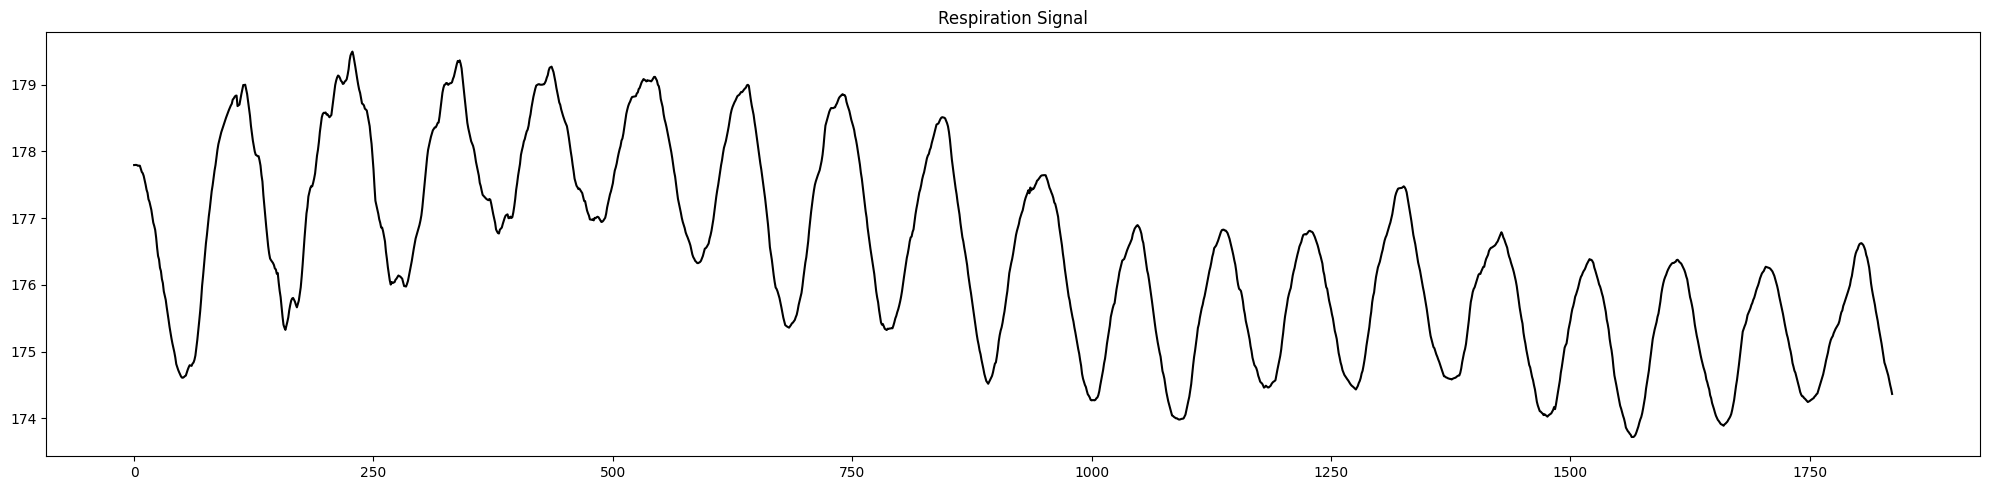

In [64]:
try:
    ## Load the Video
    file_path = os.path.join("Bintang_resp.mp4") ## Path to the video file
    
    ## Put 0 to use the camera, or use the video file path for analyzing a video
    cap = cv2.VideoCapture(file_path) 

    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    ## Untuk mendapatkan 60 detik video.
    while len(frame_buffer) < frame_buffer_limit:

        ## Read the frame from the camera
        ret, frame = cap.read() 
        if not ret:
            print("Error: Could not read frame.")
            break

        frame = cv2.resize(frame, STANDARD_SIZE)
        ## Adding the frame_buffer to the list
        frame_buffer.append(frame)

        if features is None:
            # Initialize ROI and feature detection
            initialize_features(frame)

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if len(features) > 10:
            new_features, status, error = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, features, None, **lk_params)
            good_old = features[status == 1]
            good_new = new_features[status == 1]
            mask = np.zeros_like(frame)
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel()
                c, d = old.ravel()
                mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
                frame = cv2.circle(frame, (int(a), int(b)), 3, (0, 255, 0), -1)
            frame = cv2.add(frame, mask)
            if len(good_new) > 0:
                avg_y = np.mean(good_new[:, 1])
                resp_signal.append(avg_y)
                features = good_new.reshape(-1, 1, 2)
            old_gray = frame_gray.copy()
        else:
            # Reinitialize features if tracking fails
            initialize_features(frame)

        ## Plot bounding box
        cv2.rectangle(frame, (int(left_x), int(top_y)), (int(right_x), int(bottom_y)), (0, 255, 0), 2)
        
        # Show the frame
        cv2.imshow("frame", frame) 

        # Check if 'q' is pressed or the window is closed
        if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("frame", cv2.WND_PROP_VISIBLE) < 1:
            break

except Exception as e:
    print(f"An error occurred: {e}")
    cap.release()
    cv2.destroyAllWindows()

finally:
    ## Release the camera and close all windows
    cap.release()
    cv2.destroyAllWindows()
    
    ## Plot the Respiration Signal
    plt.figure(figsize=(20, 5))
    plt.plot(resp_signal, color='black')
    plt.title('Respiration Signal')
    plt.tight_layout()
    plt.show()
